# Importing

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [9]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask)


# Masking

In [10]:
def masking (depth, temp, saline, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    return (temp, saline)


# SOM

In [11]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2.transpose(), predictions, clusters)


# Printing

In [12]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [13]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('tab10', unique.max()+1)
    cmap.set_bad('gray')

    clus = map.plot.pcolormesh(ax=ax, cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique)
    cbar.set_label('Clusters [count]')

    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 9738 

The minimum temperature for cluster 0 is 7.85 degrees Celsius
The maximum temperature for cluster 0 is 10.58 degrees Celsius
The mean temperature for cluster 0 is 9.28 degrees Celsius 

The minimum salinity for cluster 0 is 21.41 g/kg
The maximum salinity for cluster 0 is 26.27 g/kg
The mean salinity for cluster 0 is 24.21 g/kg 


The amount of grid boxes for cluster 1 is 10906 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 11.04 degrees Celsius
The mean temperature for cluster 1 is 8.99 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 22.96 g/kg
The mean salinity for cluster 1 is 17.08 g/kg 


The amount of grid boxes for cluster 2 is 15494 

The minimum temperature for cluster 2 is 8.65 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 9.01 degrees Celsius 

T

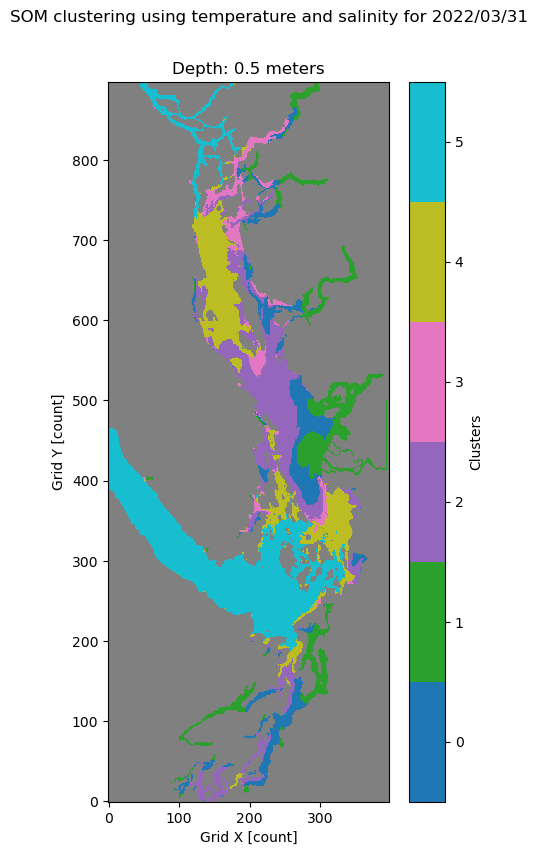

The amount of grid boxes for cluster 0 is 8543 

The minimum temperature for cluster 0 is 7.42 degrees Celsius
The maximum temperature for cluster 0 is 9.38 degrees Celsius
The mean temperature for cluster 0 is 8.39 degrees Celsius 

The minimum salinity for cluster 0 is 26.59 g/kg
The maximum salinity for cluster 0 is 30.62 g/kg
The mean salinity for cluster 0 is 28.6 g/kg 


The amount of grid boxes for cluster 1 is 26847 

The minimum temperature for cluster 1 is 6.72 degrees Celsius
The maximum temperature for cluster 1 is 9.17 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 27.93 g/kg
The maximum salinity for cluster 1 is 31.32 g/kg
The mean salinity for cluster 1 is 30.33 g/kg 


The amount of grid boxes for cluster 2 is 13866 

The minimum temperature for cluster 2 is 7.7 degrees Celsius
The maximum temperature for cluster 2 is 9.91 degrees Celsius
The mean temperature for cluster 2 is 8.87 degrees Celsius 

The 

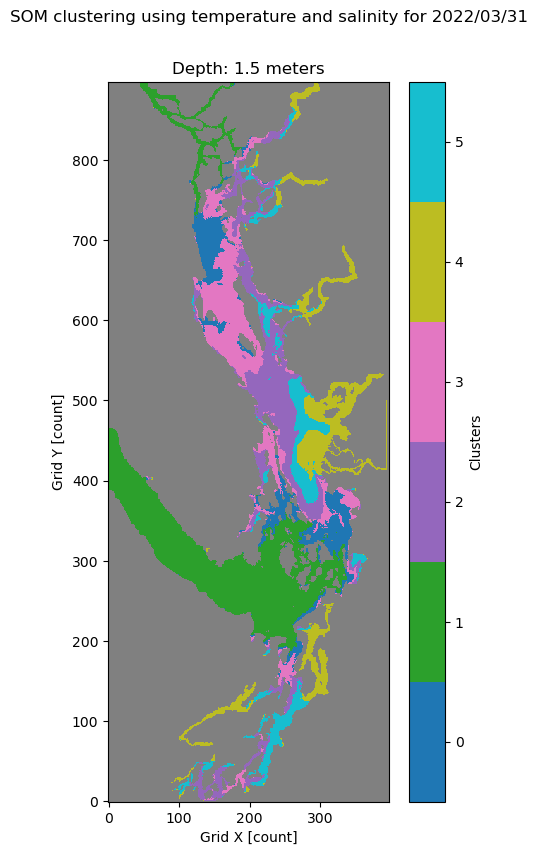

The amount of grid boxes for cluster 0 is 26666 

The minimum temperature for cluster 0 is 6.73 degrees Celsius
The maximum temperature for cluster 0 is 9.29 degrees Celsius
The mean temperature for cluster 0 is 7.97 degrees Celsius 

The minimum salinity for cluster 0 is 28.72 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.36 g/kg 


The amount of grid boxes for cluster 1 is 8434 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 9.06 degrees Celsius
The mean temperature for cluster 1 is 8.28 degrees Celsius 

The minimum salinity for cluster 1 is 26.63 g/kg
The maximum salinity for cluster 1 is 29.92 g/kg
The mean salinity for cluster 1 is 28.64 g/kg 


The amount of grid boxes for cluster 2 is 15658 

The minimum temperature for cluster 2 is 7.78 degrees Celsius
The maximum temperature for cluster 2 is 9.98 degrees Celsius
The mean temperature for cluster 2 is 8.59 degrees Celsius 

Th

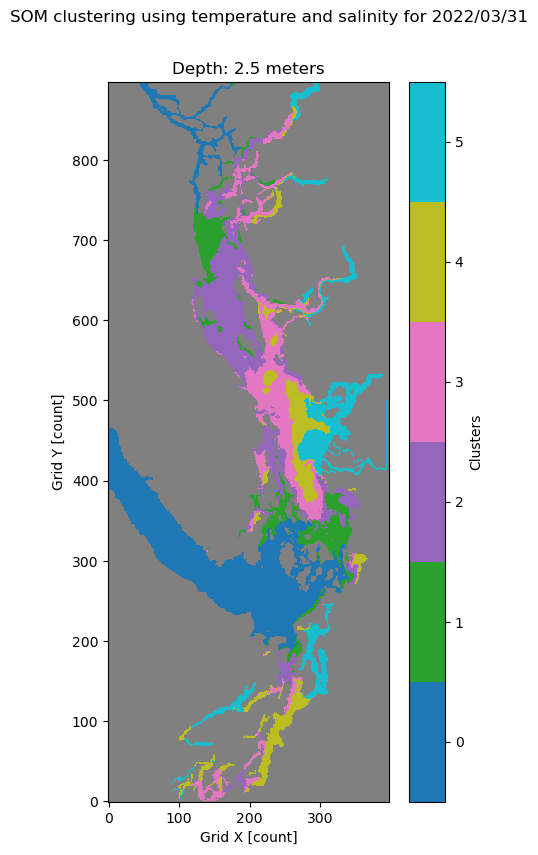

The amount of grid boxes for cluster 0 is 9527 

The minimum temperature for cluster 0 is 7.82 degrees Celsius
The maximum temperature for cluster 0 is 9.34 degrees Celsius
The mean temperature for cluster 0 is 8.3 degrees Celsius 

The minimum salinity for cluster 0 is 28.34 g/kg
The maximum salinity for cluster 0 is 30.67 g/kg
The mean salinity for cluster 0 is 28.92 g/kg 


The amount of grid boxes for cluster 1 is 25324 

The minimum temperature for cluster 1 is 6.71 degrees Celsius
The maximum temperature for cluster 1 is 8.68 degrees Celsius
The mean temperature for cluster 1 is 7.94 degrees Celsius 

The minimum salinity for cluster 1 is 28.73 g/kg
The maximum salinity for cluster 1 is 31.33 g/kg
The mean salinity for cluster 1 is 30.43 g/kg 


The amount of grid boxes for cluster 2 is 16187 

The minimum temperature for cluster 2 is 8.31 degrees Celsius
The maximum temperature for cluster 2 is 9.71 degrees Celsius
The mean temperature for cluster 2 is 8.64 degrees Celsius 

The

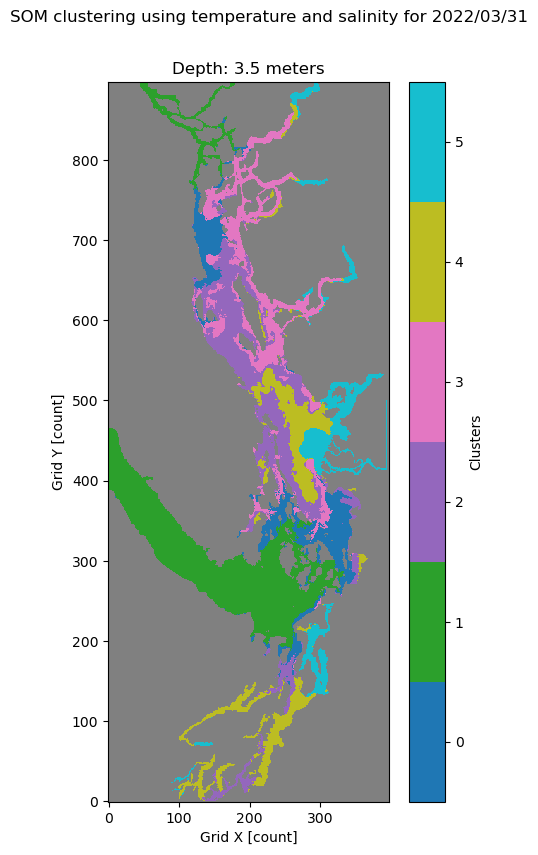

The amount of grid boxes for cluster 0 is 24628 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 9.07 degrees Celsius
The mean temperature for cluster 0 is 7.94 degrees Celsius 

The minimum salinity for cluster 0 is 29.45 g/kg
The maximum salinity for cluster 0 is 31.36 g/kg
The mean salinity for cluster 0 is 30.48 g/kg 


The amount of grid boxes for cluster 1 is 5282 

The minimum temperature for cluster 1 is 6.67 degrees Celsius
The maximum temperature for cluster 1 is 8.38 degrees Celsius
The mean temperature for cluster 1 is 8.04 degrees Celsius 

The minimum salinity for cluster 1 is 27.84 g/kg
The maximum salinity for cluster 1 is 29.5 g/kg
The mean salinity for cluster 1 is 29.0 g/kg 


The amount of grid boxes for cluster 2 is 17385 

The minimum temperature for cluster 2 is 8.0 degrees Celsius
The maximum temperature for cluster 2 is 9.36 degrees Celsius
The mean temperature for cluster 2 is 8.37 degrees Celsius 

The m

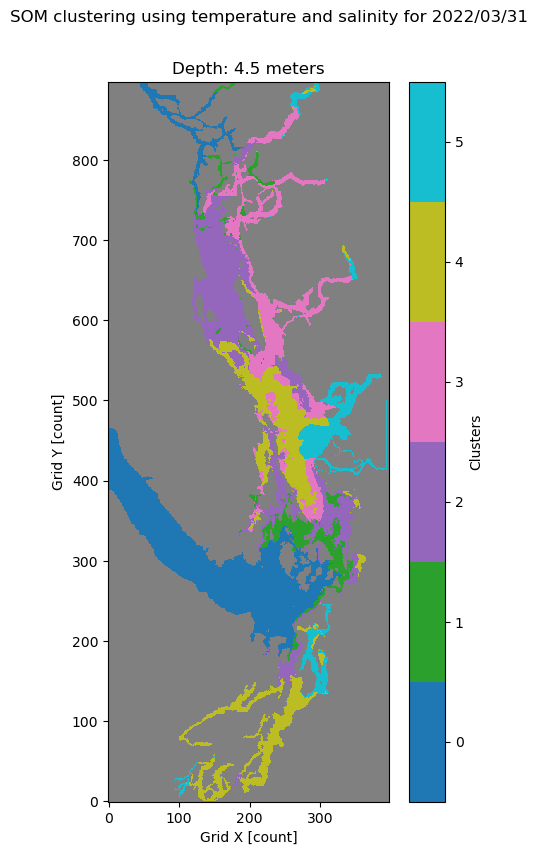

The amount of grid boxes for cluster 0 is 23536 

The minimum temperature for cluster 0 is 6.54 degrees Celsius
The maximum temperature for cluster 0 is 8.45 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 29.05 g/kg
The maximum salinity for cluster 0 is 31.39 g/kg
The mean salinity for cluster 0 is 30.53 g/kg 


The amount of grid boxes for cluster 1 is 8269 

The minimum temperature for cluster 1 is 7.85 degrees Celsius
The maximum temperature for cluster 1 is 9.05 degrees Celsius
The mean temperature for cluster 1 is 8.19 degrees Celsius 

The minimum salinity for cluster 1 is 28.77 g/kg
The maximum salinity for cluster 1 is 30.65 g/kg
The mean salinity for cluster 1 is 29.22 g/kg 


The amount of grid boxes for cluster 2 is 13717 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 8.23 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

Th

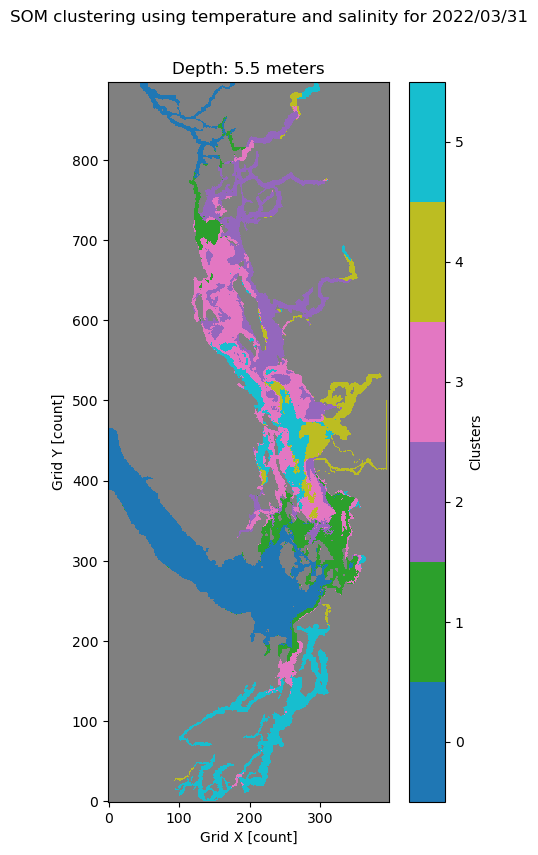

The amount of grid boxes for cluster 0 is 14885 

The minimum temperature for cluster 0 is 8.17 degrees Celsius
The maximum temperature for cluster 0 is 10.32 degrees Celsius
The mean temperature for cluster 0 is 8.74 degrees Celsius 

The minimum salinity for cluster 0 is 24.41 g/kg
The maximum salinity for cluster 0 is 29.32 g/kg
The mean salinity for cluster 0 is 27.45 g/kg 


The amount of grid boxes for cluster 1 is 4274 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.23 degrees Celsius
The mean temperature for cluster 1 is 7.95 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 27.53 g/kg
The mean salinity for cluster 1 is 23.62 g/kg 


The amount of grid boxes for cluster 2 is 17158 

The minimum temperature for cluster 2 is 8.04 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 8.25 degrees Celsius 

The

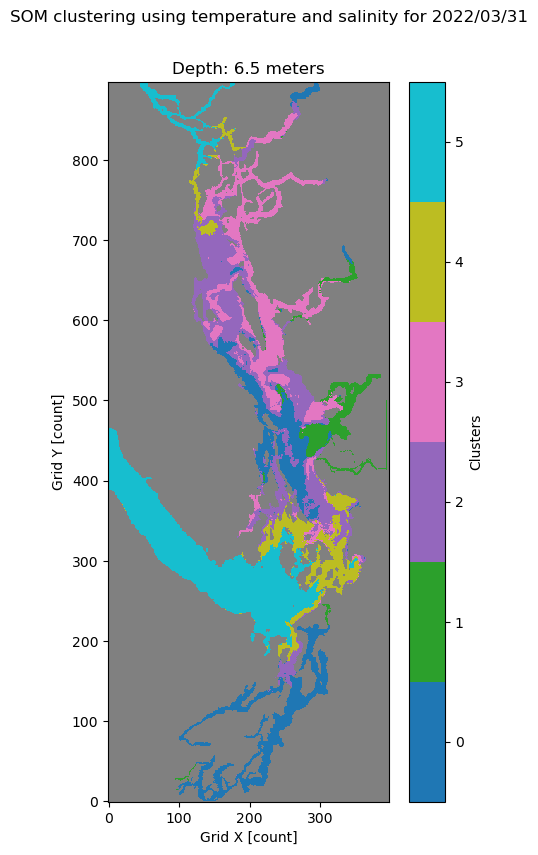

The amount of grid boxes for cluster 0 is 21833 

The minimum temperature for cluster 0 is 7.4 degrees Celsius
The maximum temperature for cluster 0 is 8.73 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 29.68 g/kg
The maximum salinity for cluster 0 is 31.44 g/kg
The mean salinity for cluster 0 is 30.62 g/kg 


The amount of grid boxes for cluster 1 is 4774 

The minimum temperature for cluster 1 is 6.19 degrees Celsius
The maximum temperature for cluster 1 is 8.14 degrees Celsius
The mean temperature for cluster 1 is 7.9 degrees Celsius 

The minimum salinity for cluster 1 is 28.89 g/kg
The maximum salinity for cluster 1 is 29.95 g/kg
The mean salinity for cluster 1 is 29.49 g/kg 


The amount of grid boxes for cluster 2 is 12834 

The minimum temperature for cluster 2 is 8.0 degrees Celsius
The maximum temperature for cluster 2 is 8.76 degrees Celsius
The mean temperature for cluster 2 is 8.22 degrees Celsius 

The m

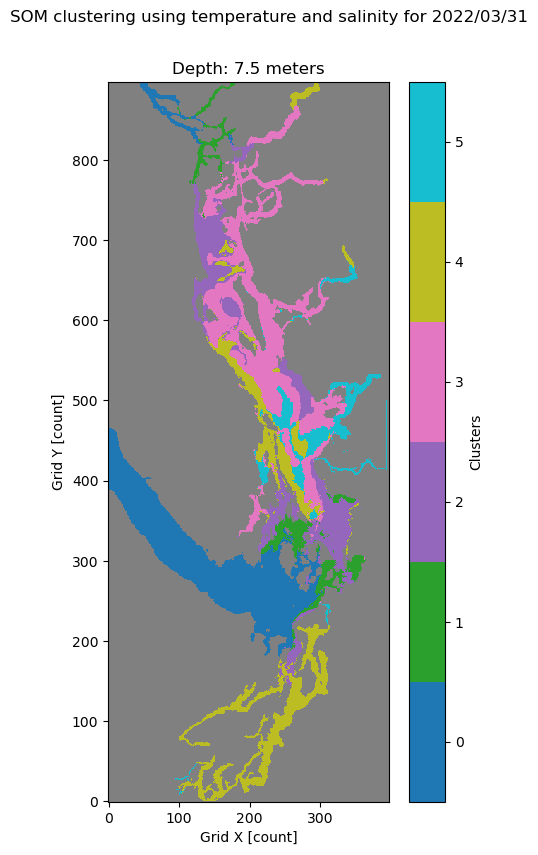

The amount of grid boxes for cluster 0 is 13223 

The minimum temperature for cluster 0 is 8.2 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.69 degrees Celsius 

The minimum salinity for cluster 0 is 24.37 g/kg
The maximum salinity for cluster 0 is 29.44 g/kg
The mean salinity for cluster 0 is 27.95 g/kg 


The amount of grid boxes for cluster 1 is 3966 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.21 degrees Celsius
The mean temperature for cluster 1 is 7.98 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.04 g/kg
The mean salinity for cluster 1 is 25.23 g/kg 


The amount of grid boxes for cluster 2 is 12361 

The minimum temperature for cluster 2 is 7.99 degrees Celsius
The maximum temperature for cluster 2 is 8.75 degrees Celsius
The mean temperature for cluster 2 is 8.19 degrees Celsius 

The 

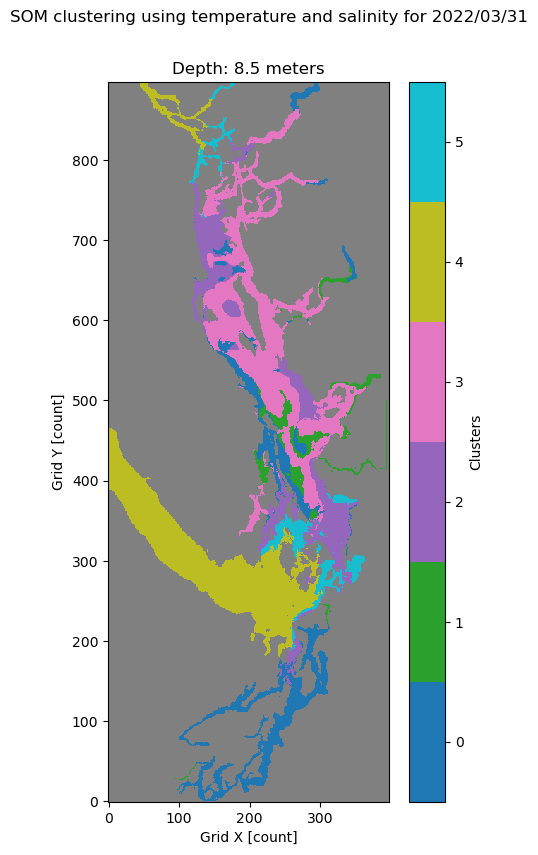

The amount of grid boxes for cluster 0 is 12164 

The minimum temperature for cluster 0 is 8.19 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.7 degrees Celsius 

The minimum salinity for cluster 0 is 22.68 g/kg
The maximum salinity for cluster 0 is 29.47 g/kg
The mean salinity for cluster 0 is 28.05 g/kg 


The amount of grid boxes for cluster 1 is 4838 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.14 degrees Celsius
The mean temperature for cluster 1 is 7.92 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.2 g/kg
The mean salinity for cluster 1 is 26.14 g/kg 


The amount of grid boxes for cluster 2 is 15682 

The minimum temperature for cluster 2 is 8.02 degrees Celsius
The maximum temperature for cluster 2 is 8.63 degrees Celsius
The mean temperature for cluster 2 is 8.17 degrees Celsius 

The m

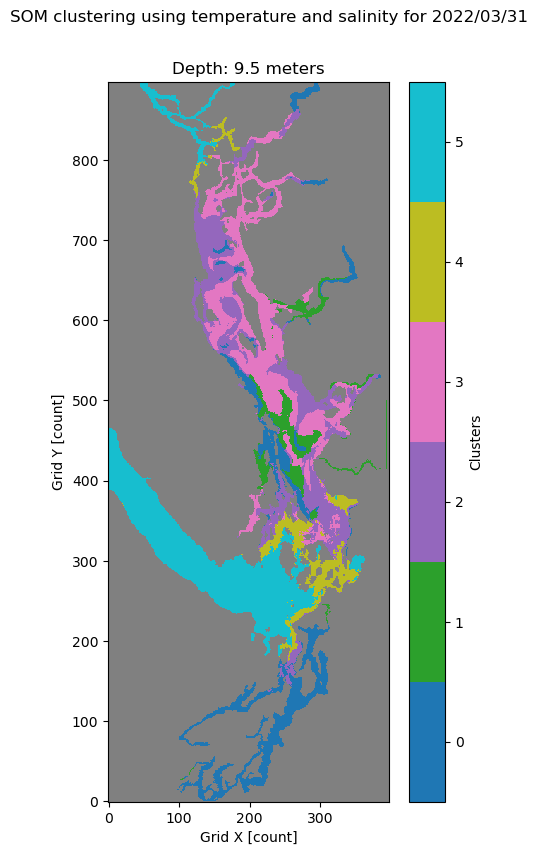

The amount of grid boxes for cluster 0 is 20348 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.85 g/kg
The maximum salinity for cluster 0 is 31.56 g/kg
The mean salinity for cluster 0 is 30.71 g/kg 


The amount of grid boxes for cluster 1 is 4026 

The minimum temperature for cluster 1 is 6.22 degrees Celsius
The maximum temperature for cluster 1 is 8.05 degrees Celsius
The mean temperature for cluster 1 is 7.81 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 30.08 g/kg
The mean salinity for cluster 1 is 29.67 g/kg 


The amount of grid boxes for cluster 2 is 12154 

The minimum temperature for cluster 2 is 7.95 degrees Celsius
The maximum temperature for cluster 2 is 8.45 degrees Celsius
The mean temperature for cluster 2 is 8.13 degrees Celsius 

Th

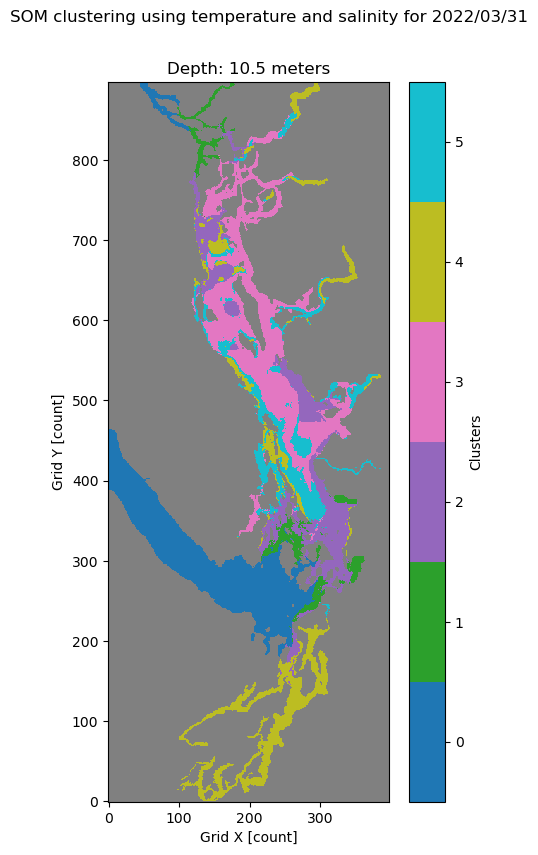

The amount of grid boxes for cluster 0 is 6588 

The minimum temperature for cluster 0 is 6.41 degrees Celsius
The maximum temperature for cluster 0 is 8.96 degrees Celsius
The mean temperature for cluster 0 is 8.11 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.86 g/kg
The mean salinity for cluster 0 is 27.61 g/kg 


The amount of grid boxes for cluster 1 is 11684 

The minimum temperature for cluster 1 is 8.25 degrees Celsius
The maximum temperature for cluster 1 is 10.43 degrees Celsius
The mean temperature for cluster 1 is 8.72 degrees Celsius 

The minimum salinity for cluster 1 is 22.16 g/kg
The maximum salinity for cluster 1 is 29.85 g/kg
The mean salinity for cluster 1 is 28.37 g/kg 


The amount of grid boxes for cluster 2 is 20334 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.12 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

The

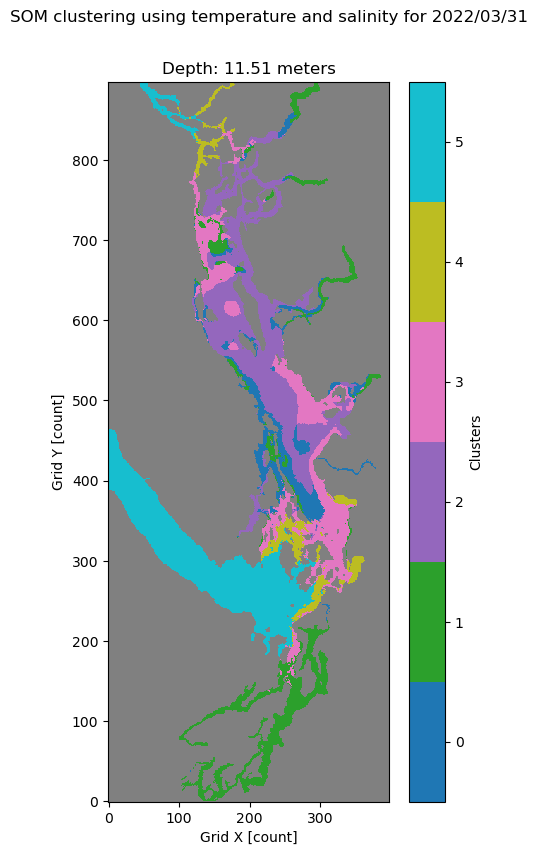

The amount of grid boxes for cluster 0 is 11284 

The minimum temperature for cluster 0 is 6.41 degrees Celsius
The maximum temperature for cluster 0 is 8.27 degrees Celsius
The mean temperature for cluster 0 is 8.05 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.89 g/kg
The mean salinity for cluster 0 is 28.16 g/kg 


The amount of grid boxes for cluster 1 is 11496 

The minimum temperature for cluster 1 is 8.27 degrees Celsius
The maximum temperature for cluster 1 is 10.5 degrees Celsius
The mean temperature for cluster 1 is 8.74 degrees Celsius 

The minimum salinity for cluster 1 is 18.83 g/kg
The maximum salinity for cluster 1 is 29.86 g/kg
The mean salinity for cluster 1 is 28.43 g/kg 


The amount of grid boxes for cluster 2 is 18307 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.07 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The

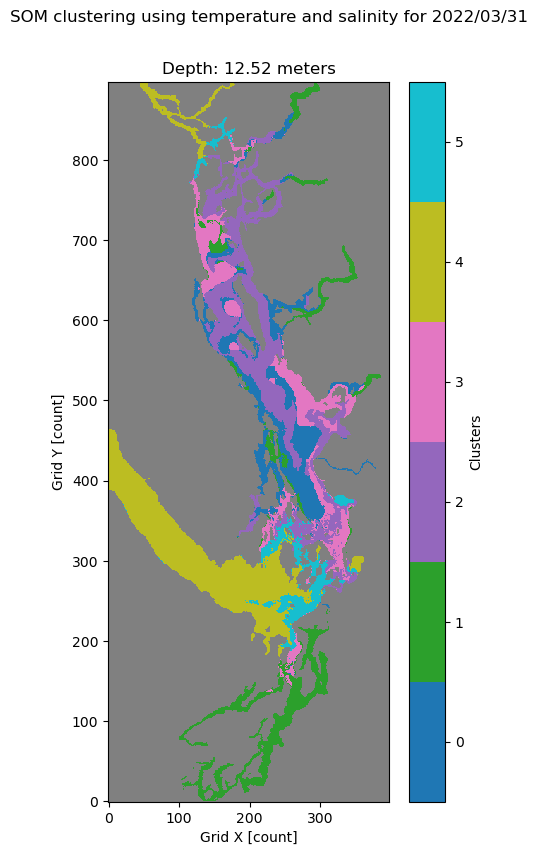

The amount of grid boxes for cluster 0 is 12610 

The minimum temperature for cluster 0 is 8.23 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.71 degrees Celsius 

The minimum salinity for cluster 0 is 22.53 g/kg
The maximum salinity for cluster 0 is 29.87 g/kg
The mean salinity for cluster 0 is 28.57 g/kg 


The amount of grid boxes for cluster 1 is 2219 

The minimum temperature for cluster 1 is 8.06 degrees Celsius
The maximum temperature for cluster 1 is 8.45 degrees Celsius
The mean temperature for cluster 1 is 8.24 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 30.93 g/kg
The mean salinity for cluster 1 is 29.41 g/kg 


The amount of grid boxes for cluster 2 is 16321 

The minimum temperature for cluster 2 is 7.96 degrees Celsius
The maximum temperature for cluster 2 is 8.27 degrees Celsius
The mean temperature for cluster 2 is 8.11 degrees Celsius 

T

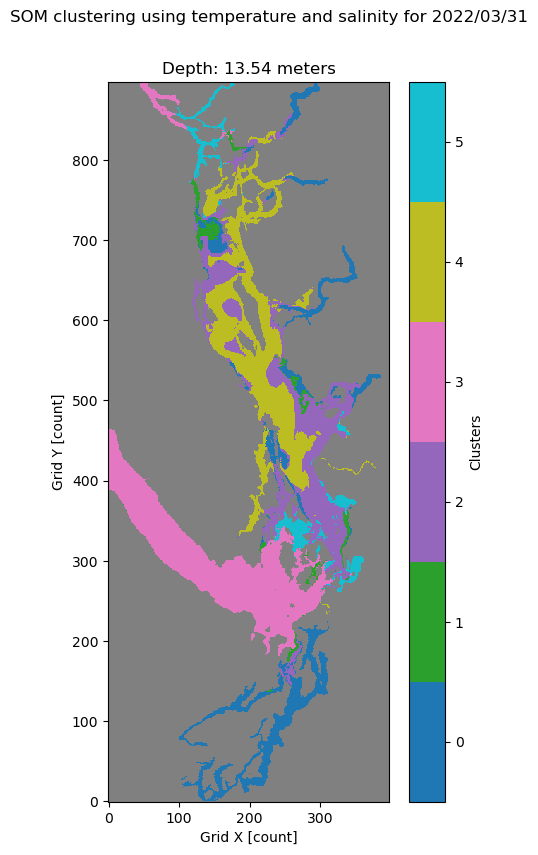

The amount of grid boxes for cluster 0 is 21538 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 8.14 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.24 g/kg
The mean salinity for cluster 0 is 28.62 g/kg 


The amount of grid boxes for cluster 1 is 8773 

The minimum temperature for cluster 1 is 8.11 degrees Celsius
The maximum temperature for cluster 1 is 9.15 degrees Celsius
The mean temperature for cluster 1 is 8.25 degrees Celsius 

The minimum salinity for cluster 1 is 19.87 g/kg
The maximum salinity for cluster 1 is 29.29 g/kg
The mean salinity for cluster 1 is 28.63 g/kg 


The amount of grid boxes for cluster 2 is 10521 

The minimum temperature for cluster 2 is 7.69 degrees Celsius
The maximum temperature for cluster 2 is 8.25 degrees Celsius
The mean temperature for cluster 2 is 8.02 degrees Celsius 

The m

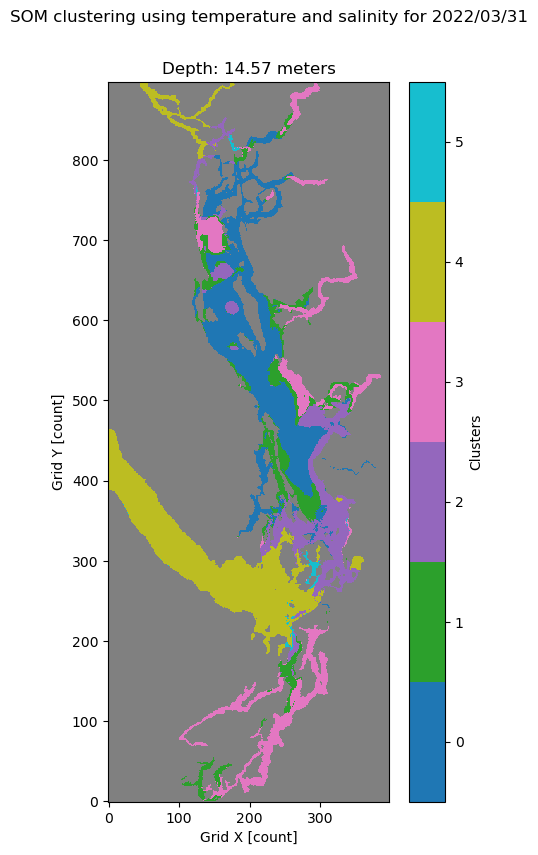

The amount of grid boxes for cluster 0 is 19090 

The minimum temperature for cluster 0 is 6.8 degrees Celsius
The maximum temperature for cluster 0 is 8.26 degrees Celsius
The mean temperature for cluster 0 is 7.81 degrees Celsius 

The minimum salinity for cluster 0 is 29.77 g/kg
The maximum salinity for cluster 0 is 31.78 g/kg
The mean salinity for cluster 0 is 30.82 g/kg 


The amount of grid boxes for cluster 1 is 4964 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.06 degrees Celsius
The mean temperature for cluster 1 is 7.89 degrees Celsius 

The minimum salinity for cluster 1 is 29.23 g/kg
The maximum salinity for cluster 1 is 30.12 g/kg
The mean salinity for cluster 1 is 29.77 g/kg 


The amount of grid boxes for cluster 2 is 4860 

The minimum temperature for cluster 2 is 7.97 degrees Celsius
The maximum temperature for cluster 2 is 8.36 degrees Celsius
The mean temperature for cluster 2 is 8.09 degrees Celsius 

The 

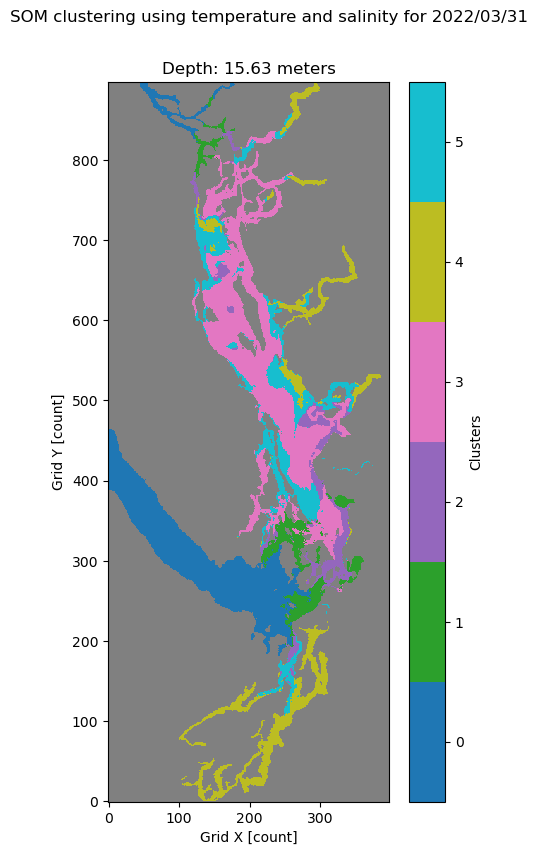

The amount of grid boxes for cluster 0 is 10934 

The minimum temperature for cluster 0 is 6.48 degrees Celsius
The maximum temperature for cluster 0 is 8.37 degrees Celsius
The mean temperature for cluster 0 is 8.23 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.66 g/kg
The mean salinity for cluster 0 is 28.93 g/kg 


The amount of grid boxes for cluster 1 is 10576 

The minimum temperature for cluster 1 is 8.37 degrees Celsius
The maximum temperature for cluster 1 is 10.49 degrees Celsius
The mean temperature for cluster 1 is 8.85 degrees Celsius 

The minimum salinity for cluster 1 is 20.27 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 28.81 g/kg 


The amount of grid boxes for cluster 2 is 23290 

The minimum temperature for cluster 2 is 7.35 degrees Celsius
The maximum temperature for cluster 2 is 8.12 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

Th

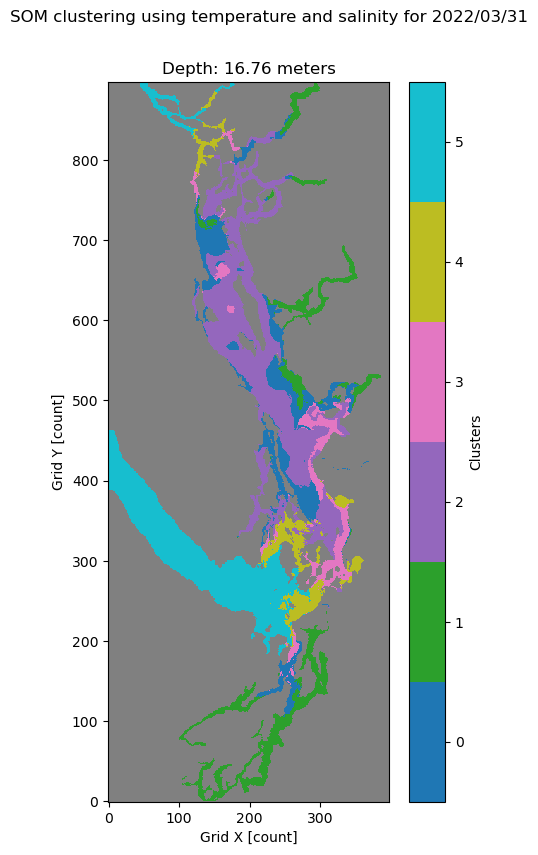

The amount of grid boxes for cluster 0 is 14192 

The minimum temperature for cluster 0 is 7.35 degrees Celsius
The maximum temperature for cluster 0 is 8.01 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 28.35 g/kg
The maximum salinity for cluster 0 is 29.89 g/kg
The mean salinity for cluster 0 is 29.02 g/kg 


The amount of grid boxes for cluster 1 is 20817 

The minimum temperature for cluster 1 is 7.06 degrees Celsius
The maximum temperature for cluster 1 is 8.22 degrees Celsius
The mean temperature for cluster 1 is 7.8 degrees Celsius 

The minimum salinity for cluster 1 is 29.69 g/kg
The maximum salinity for cluster 1 is 31.89 g/kg
The mean salinity for cluster 1 is 30.77 g/kg 


The amount of grid boxes for cluster 2 is 18762 

The minimum temperature for cluster 2 is 6.48 degrees Celsius
The maximum temperature for cluster 2 is 8.27 degrees Celsius
The mean temperature for cluster 2 is 8.09 degrees Celsius 

Th

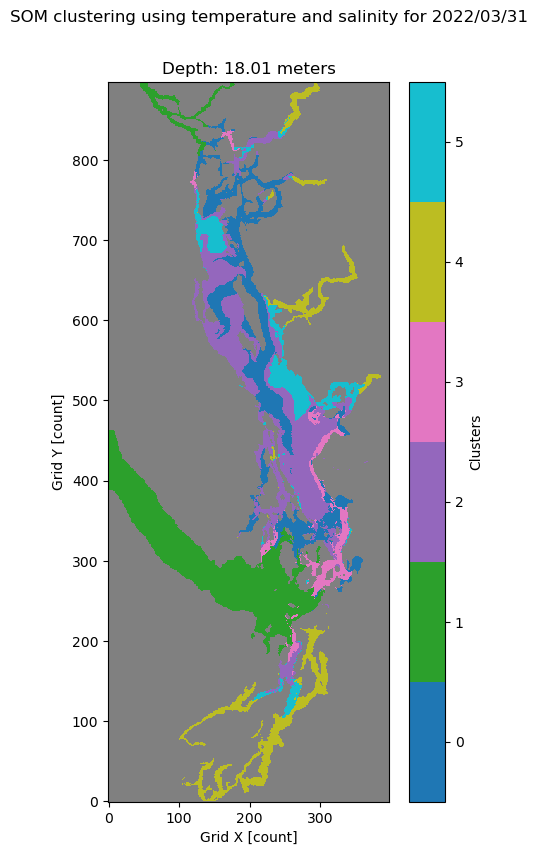

The amount of grid boxes for cluster 0 is 17618 

The minimum temperature for cluster 0 is 7.15 degrees Celsius
The maximum temperature for cluster 0 is 8.06 degrees Celsius
The mean temperature for cluster 0 is 7.77 degrees Celsius 

The minimum salinity for cluster 0 is 29.53 g/kg
The maximum salinity for cluster 0 is 31.97 g/kg
The mean salinity for cluster 0 is 30.9 g/kg 


The amount of grid boxes for cluster 1 is 4212 

The minimum temperature for cluster 1 is 7.72 degrees Celsius
The maximum temperature for cluster 1 is 8.18 degrees Celsius
The mean temperature for cluster 1 is 7.9 degrees Celsius 

The minimum salinity for cluster 1 is 29.51 g/kg
The maximum salinity for cluster 1 is 31.27 g/kg
The mean salinity for cluster 1 is 30.07 g/kg 


The amount of grid boxes for cluster 2 is 23467 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.08 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

The 

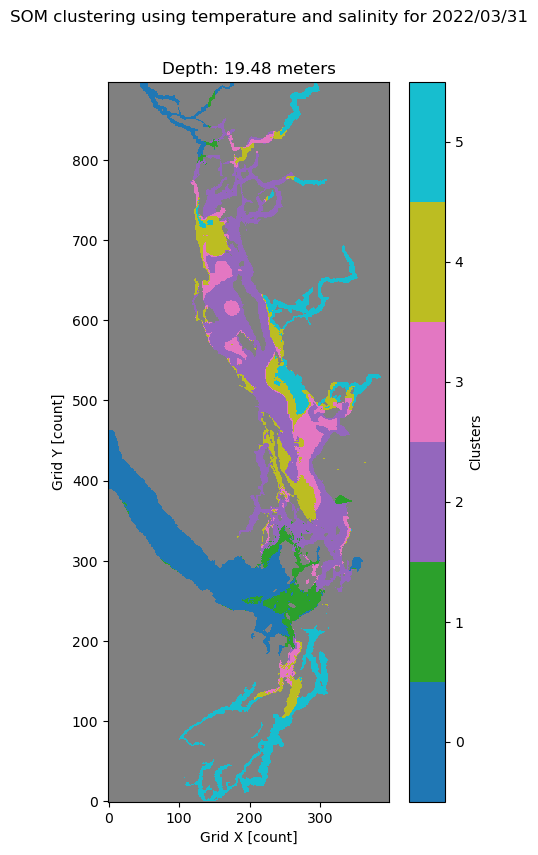

The amount of grid boxes for cluster 0 is 210 

The minimum temperature for cluster 0 is 7.98 degrees Celsius
The maximum temperature for cluster 0 is 8.31 degrees Celsius
The mean temperature for cluster 0 is 8.1 degrees Celsius 

The minimum salinity for cluster 0 is 29.68 g/kg
The maximum salinity for cluster 0 is 31.16 g/kg
The mean salinity for cluster 0 is 30.0 g/kg 


The amount of grid boxes for cluster 1 is 20718 

The minimum temperature for cluster 1 is 7.14 degrees Celsius
The maximum temperature for cluster 1 is 8.11 degrees Celsius
The mean temperature for cluster 1 is 7.77 degrees Celsius 

The minimum salinity for cluster 1 is 29.54 g/kg
The maximum salinity for cluster 1 is 32.1 g/kg
The mean salinity for cluster 1 is 30.81 g/kg 


The amount of grid boxes for cluster 2 is 12765 

The minimum temperature for cluster 2 is 8.25 degrees Celsius
The maximum temperature for cluster 2 is 10.23 degrees Celsius
The mean temperature for cluster 2 is 8.79 degrees Celsius 

The m

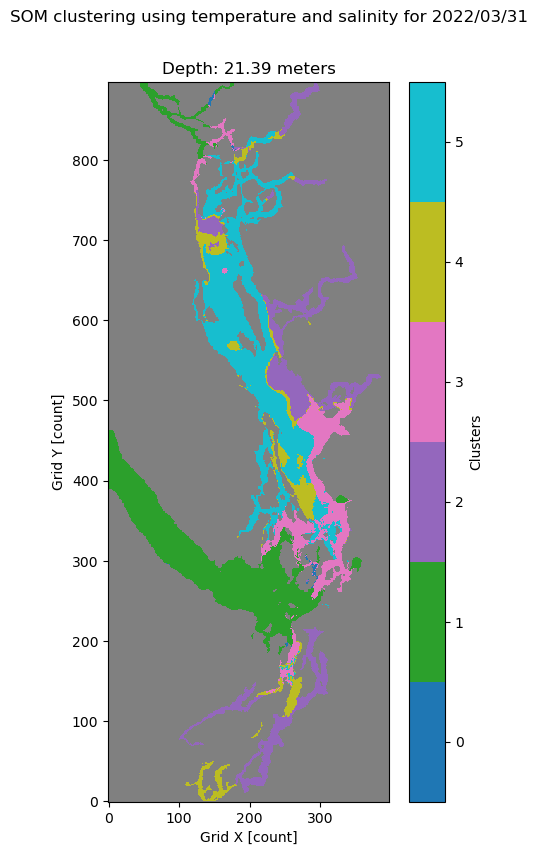

The amount of grid boxes for cluster 0 is 11313 

The minimum temperature for cluster 0 is 8.07 degrees Celsius
The maximum temperature for cluster 0 is 8.37 degrees Celsius
The mean temperature for cluster 0 is 8.21 degrees Celsius 

The minimum salinity for cluster 0 is 28.18 g/kg
The maximum salinity for cluster 0 is 29.86 g/kg
The mean salinity for cluster 0 is 29.21 g/kg 


The amount of grid boxes for cluster 1 is 13201 

The minimum temperature for cluster 1 is 8.37 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.81 degrees Celsius 

The minimum salinity for cluster 1 is 26.4 g/kg
The maximum salinity for cluster 1 is 29.91 g/kg
The mean salinity for cluster 1 is 29.25 g/kg 


The amount of grid boxes for cluster 2 is 19362 

The minimum temperature for cluster 2 is 7.66 degrees Celsius
The maximum temperature for cluster 2 is 8.12 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

Th

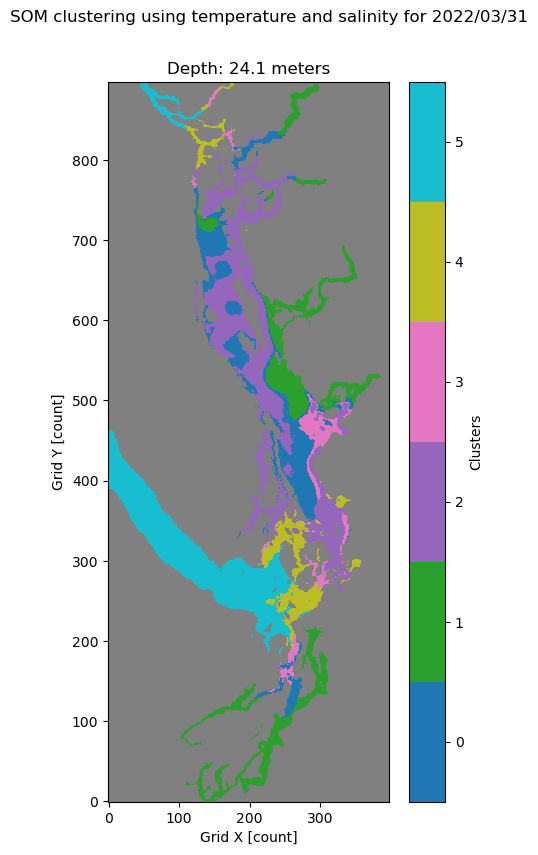

The amount of grid boxes for cluster 0 is 17124 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 8.05 degrees Celsius
The mean temperature for cluster 0 is 7.71 degrees Celsius 

The minimum salinity for cluster 0 is 29.94 g/kg
The maximum salinity for cluster 0 is 32.44 g/kg
The mean salinity for cluster 0 is 31.08 g/kg 


The amount of grid boxes for cluster 1 is 7382 

The minimum temperature for cluster 1 is 7.34 degrees Celsius
The maximum temperature for cluster 1 is 8.02 degrees Celsius
The mean temperature for cluster 1 is 7.87 degrees Celsius 

The minimum salinity for cluster 1 is 28.42 g/kg
The maximum salinity for cluster 1 is 30.47 g/kg
The mean salinity for cluster 1 is 29.75 g/kg 


The amount of grid boxes for cluster 2 is 1029 

The minimum temperature for cluster 2 is 8.03 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 8.17 degrees Celsius 

The 

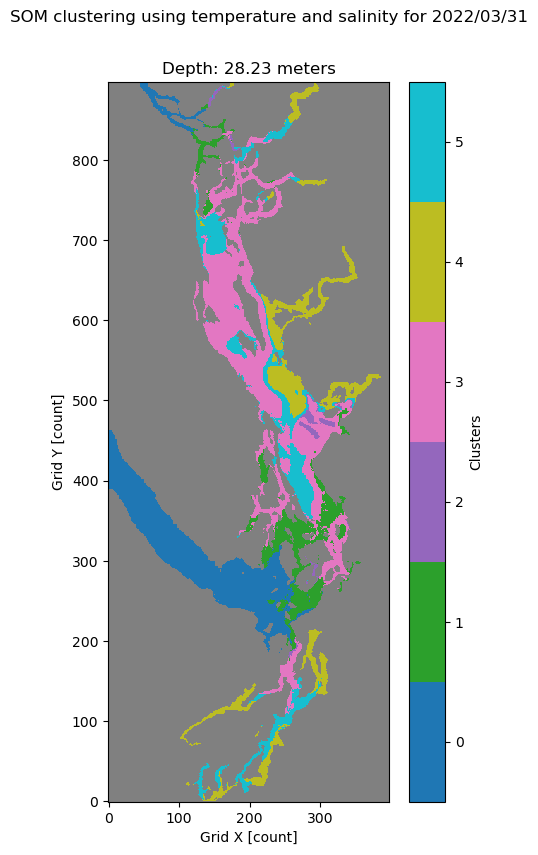

The amount of grid boxes for cluster 0 is 8430 

The minimum temperature for cluster 0 is 8.2 degrees Celsius
The maximum temperature for cluster 0 is 8.47 degrees Celsius
The mean temperature for cluster 0 is 8.36 degrees Celsius 

The minimum salinity for cluster 0 is 27.3 g/kg
The maximum salinity for cluster 0 is 30.23 g/kg
The mean salinity for cluster 0 is 29.43 g/kg 


The amount of grid boxes for cluster 1 is 11970 

The minimum temperature for cluster 1 is 8.46 degrees Celsius
The maximum temperature for cluster 1 is 10.21 degrees Celsius
The mean temperature for cluster 1 is 8.87 degrees Celsius 

The minimum salinity for cluster 1 is 26.82 g/kg
The maximum salinity for cluster 1 is 30.33 g/kg
The mean salinity for cluster 1 is 29.55 g/kg 


The amount of grid boxes for cluster 2 is 10105 

The minimum temperature for cluster 2 is 7.68 degrees Celsius
The maximum temperature for cluster 2 is 8.18 degrees Celsius
The mean temperature for cluster 2 is 7.98 degrees Celsius 

The

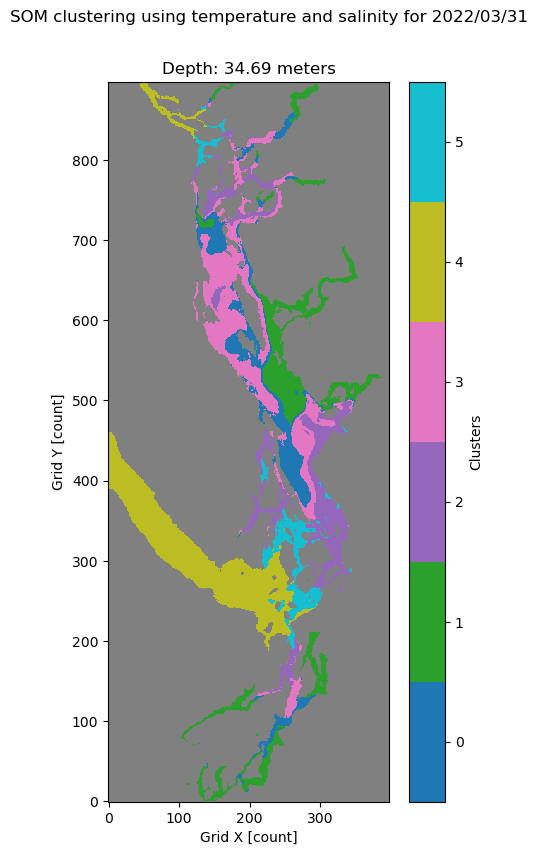

The amount of grid boxes for cluster 0 is 13657 

The minimum temperature for cluster 0 is 8.17 degrees Celsius
The maximum temperature for cluster 0 is 8.55 degrees Celsius
The mean temperature for cluster 0 is 8.39 degrees Celsius 

The minimum salinity for cluster 0 is 27.34 g/kg
The maximum salinity for cluster 0 is 30.27 g/kg
The mean salinity for cluster 0 is 29.53 g/kg 


The amount of grid boxes for cluster 1 is 12741 

The minimum temperature for cluster 1 is 8.49 degrees Celsius
The maximum temperature for cluster 1 is 10.31 degrees Celsius
The mean temperature for cluster 1 is 8.86 degrees Celsius 

The minimum salinity for cluster 1 is 26.9 g/kg
The maximum salinity for cluster 1 is 30.38 g/kg
The mean salinity for cluster 1 is 29.77 g/kg 


The amount of grid boxes for cluster 2 is 8479 

The minimum temperature for cluster 2 is 7.69 degrees Celsius
The maximum temperature for cluster 2 is 8.15 degrees Celsius
The mean temperature for cluster 2 is 7.95 degrees Celsius 

Th

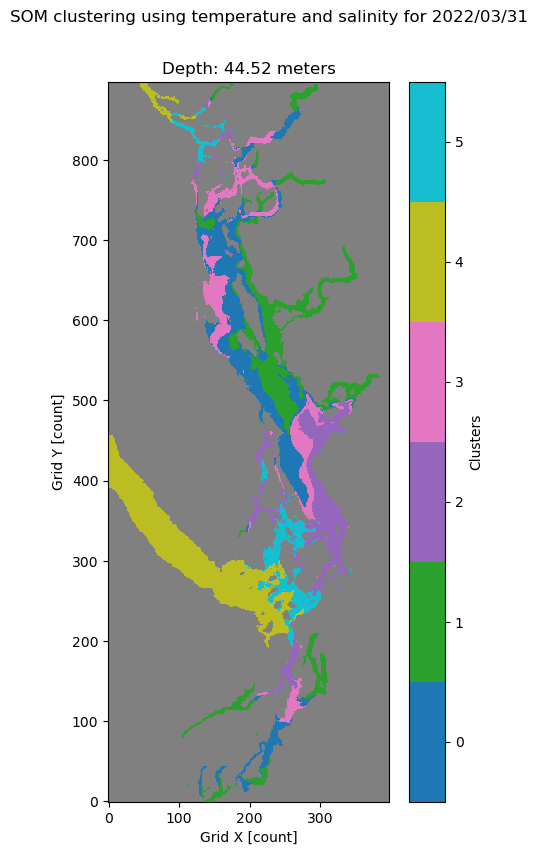

The amount of grid boxes for cluster 0 is 13944 

The minimum temperature for cluster 0 is 8.54 degrees Celsius
The maximum temperature for cluster 0 is 10.39 degrees Celsius
The mean temperature for cluster 0 is 8.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.46 g/kg
The maximum salinity for cluster 0 is 30.47 g/kg
The mean salinity for cluster 0 is 29.95 g/kg 


The amount of grid boxes for cluster 1 is 14547 

The minimum temperature for cluster 1 is 8.23 degrees Celsius
The maximum temperature for cluster 1 is 8.66 degrees Celsius
The mean temperature for cluster 1 is 8.42 degrees Celsius 

The minimum salinity for cluster 1 is 27.44 g/kg
The maximum salinity for cluster 1 is 30.32 g/kg
The mean salinity for cluster 1 is 29.67 g/kg 


The amount of grid boxes for cluster 2 is 65 

The minimum temperature for cluster 2 is 8.14 degrees Celsius
The maximum temperature for cluster 2 is 8.35 degrees Celsius
The mean temperature for cluster 2 is 8.26 degrees Celsius 

The

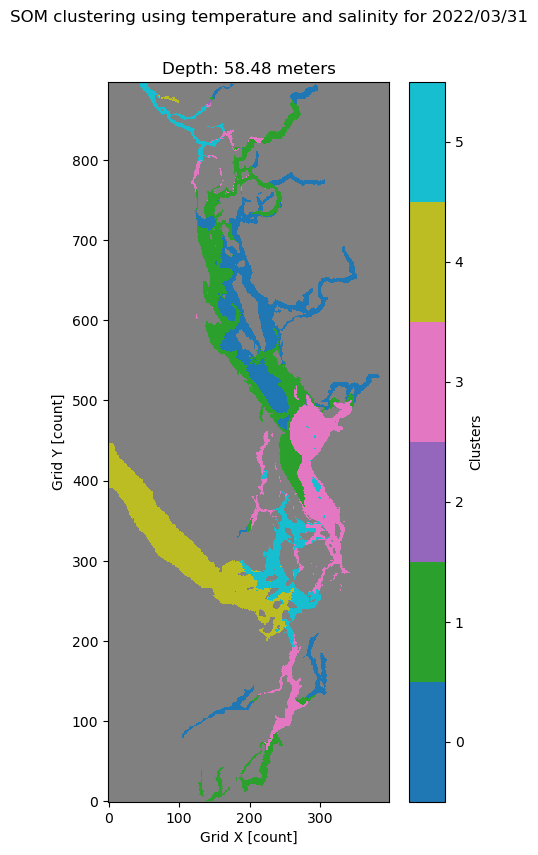

The amount of grid boxes for cluster 0 is 15645 

The minimum temperature for cluster 0 is 8.59 degrees Celsius
The maximum temperature for cluster 0 is 10.45 degrees Celsius
The mean temperature for cluster 0 is 8.88 degrees Celsius 

The minimum salinity for cluster 0 is 27.96 g/kg
The maximum salinity for cluster 0 is 30.53 g/kg
The mean salinity for cluster 0 is 30.05 g/kg 


The amount of grid boxes for cluster 1 is 6756 

The minimum temperature for cluster 1 is 8.29 degrees Celsius
The maximum temperature for cluster 1 is 8.62 degrees Celsius
The mean temperature for cluster 1 is 8.49 degrees Celsius 

The minimum salinity for cluster 1 is 27.51 g/kg
The maximum salinity for cluster 1 is 30.35 g/kg
The mean salinity for cluster 1 is 29.81 g/kg 


The amount of grid boxes for cluster 2 is 5494 

The minimum temperature for cluster 2 is 8.03 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 8.23 degrees Celsius 

The

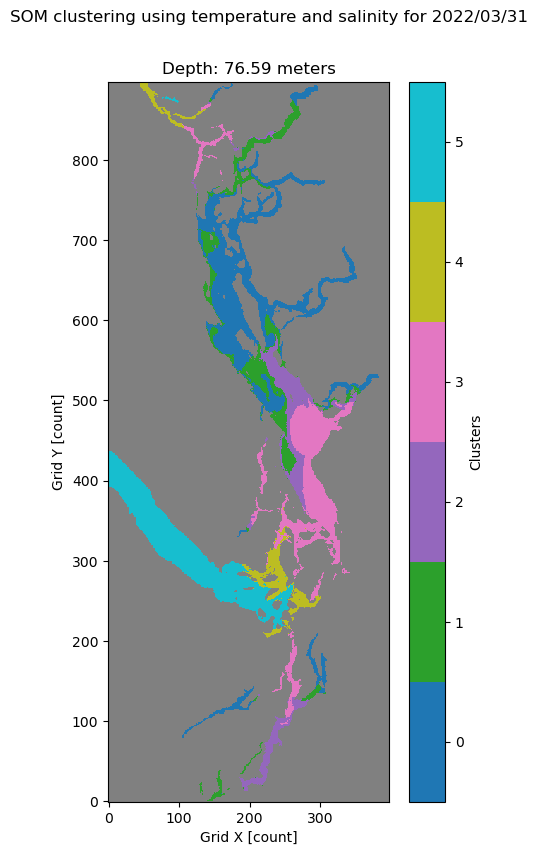

The amount of grid boxes for cluster 0 is 1684 

The minimum temperature for cluster 0 is 7.41 degrees Celsius
The maximum temperature for cluster 0 is 7.71 degrees Celsius
The mean temperature for cluster 0 is 7.62 degrees Celsius 

The minimum salinity for cluster 0 is 30.17 g/kg
The maximum salinity for cluster 0 is 31.74 g/kg
The mean salinity for cluster 0 is 31.03 g/kg 


The amount of grid boxes for cluster 1 is 10476 

The minimum temperature for cluster 1 is 7.07 degrees Celsius
The maximum temperature for cluster 1 is 7.53 degrees Celsius
The mean temperature for cluster 1 is 7.26 degrees Celsius 

The minimum salinity for cluster 1 is 31.01 g/kg
The maximum salinity for cluster 1 is 33.55 g/kg
The mean salinity for cluster 1 is 32.93 g/kg 


The amount of grid boxes for cluster 2 is 6390 

The minimum temperature for cluster 2 is 7.98 degrees Celsius
The maximum temperature for cluster 2 is 8.36 degrees Celsius
The mean temperature for cluster 2 is 8.16 degrees Celsius 

The

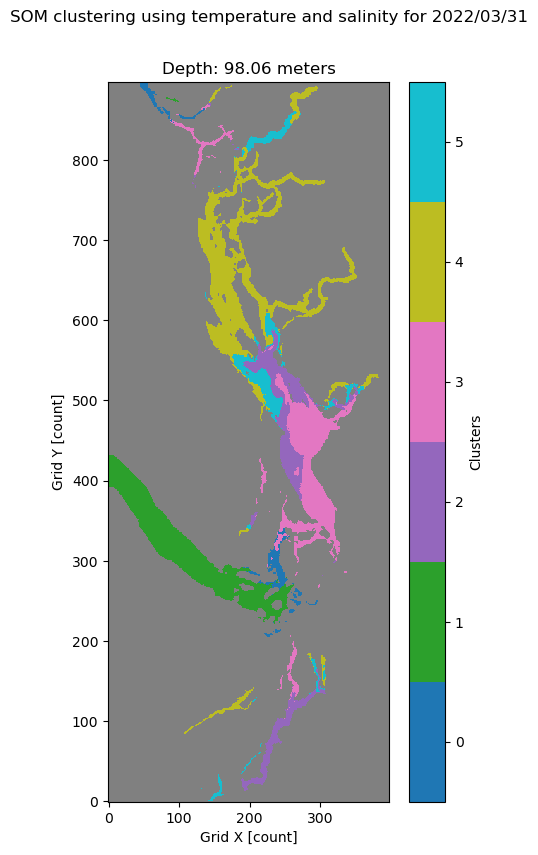

The amount of grid boxes for cluster 0 is 8777 

The minimum temperature for cluster 0 is 6.94 degrees Celsius
The maximum temperature for cluster 0 is 7.5 degrees Celsius
The mean temperature for cluster 0 is 7.18 degrees Celsius 

The minimum salinity for cluster 0 is 31.78 g/kg
The maximum salinity for cluster 0 is 33.68 g/kg
The mean salinity for cluster 0 is 33.18 g/kg 


The amount of grid boxes for cluster 1 is 1763 

The minimum temperature for cluster 1 is 7.29 degrees Celsius
The maximum temperature for cluster 1 is 7.75 degrees Celsius
The mean temperature for cluster 1 is 7.63 degrees Celsius 

The minimum salinity for cluster 1 is 29.98 g/kg
The maximum salinity for cluster 1 is 31.79 g/kg
The mean salinity for cluster 1 is 30.85 g/kg 


The amount of grid boxes for cluster 2 is 231 

The minimum temperature for cluster 2 is 8.24 degrees Celsius
The maximum temperature for cluster 2 is 8.29 degrees Celsius
The mean temperature for cluster 2 is 8.27 degrees Celsius 

The mi

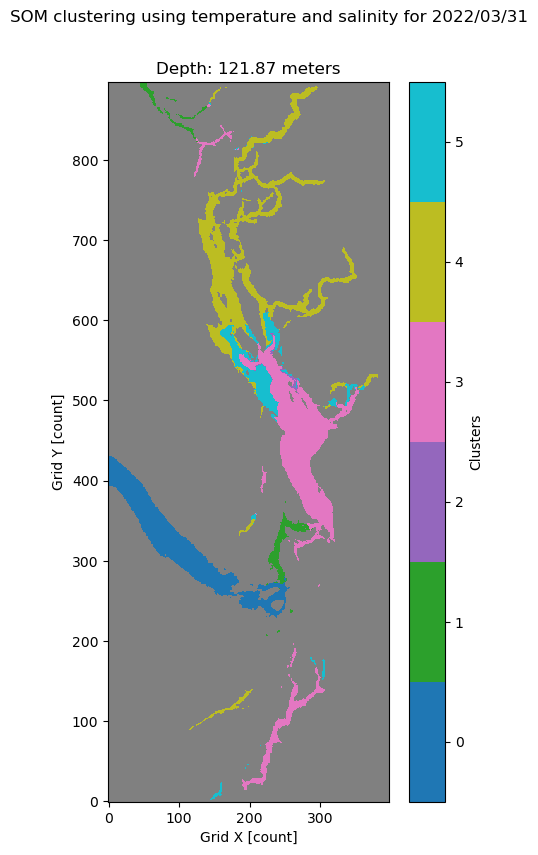

The amount of grid boxes for cluster 0 is 12110 

The minimum temperature for cluster 0 is 8.73 degrees Celsius
The maximum temperature for cluster 0 is 10.78 degrees Celsius
The mean temperature for cluster 0 is 9.1 degrees Celsius 

The minimum salinity for cluster 0 is 29.81 g/kg
The maximum salinity for cluster 0 is 30.87 g/kg
The mean salinity for cluster 0 is 30.54 g/kg 


The amount of grid boxes for cluster 1 is 2737 

The minimum temperature for cluster 1 is 8.29 degrees Celsius
The maximum temperature for cluster 1 is 8.74 degrees Celsius
The mean temperature for cluster 1 is 8.55 degrees Celsius 

The minimum salinity for cluster 1 is 28.18 g/kg
The maximum salinity for cluster 1 is 30.63 g/kg
The mean salinity for cluster 1 is 30.45 g/kg 


The amount of grid boxes for cluster 2 is 577 

The minimum temperature for cluster 2 is 8.22 degrees Celsius
The maximum temperature for cluster 2 is 8.35 degrees Celsius
The mean temperature for cluster 2 is 8.29 degrees Celsius 

The 

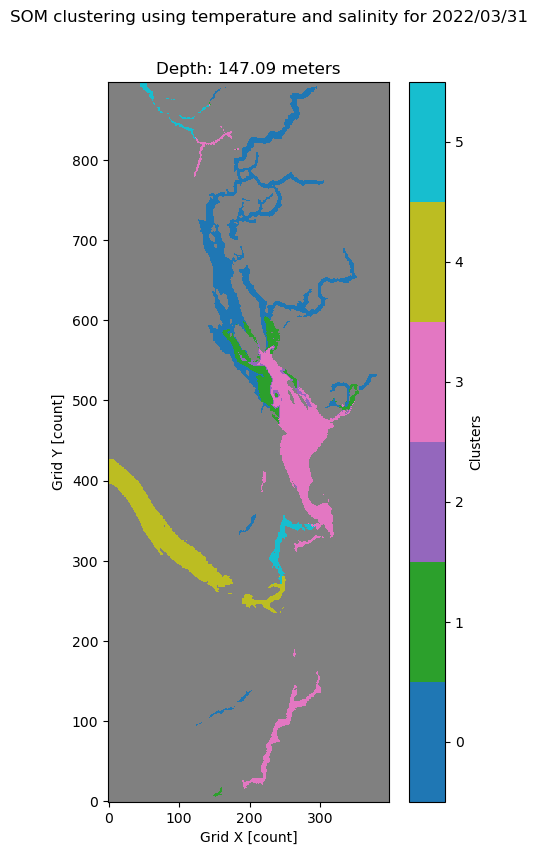

The amount of grid boxes for cluster 0 is 4699 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 7.51 degrees Celsius
The mean temperature for cluster 0 is 7.01 degrees Celsius 

The minimum salinity for cluster 0 is 31.06 g/kg
The maximum salinity for cluster 0 is 33.84 g/kg
The mean salinity for cluster 0 is 33.54 g/kg 


The amount of grid boxes for cluster 1 is 899 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 7.71 degrees Celsius
The mean temperature for cluster 1 is 7.62 degrees Celsius 

The minimum salinity for cluster 1 is 30.12 g/kg
The maximum salinity for cluster 1 is 31.68 g/kg
The mean salinity for cluster 1 is 30.98 g/kg 


The amount of grid boxes for cluster 2 is 7844 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 8.28 degrees Celsius
The mean temperature for cluster 2 is 8.01 degrees Celsius 

The m

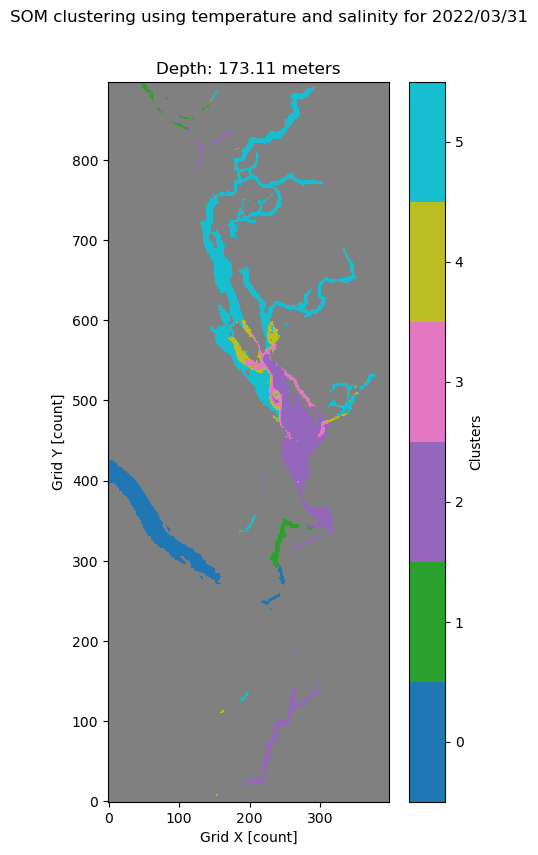

The amount of grid boxes for cluster 0 is 9999 

The minimum temperature for cluster 0 is 8.99 degrees Celsius
The maximum temperature for cluster 0 is 9.92 degrees Celsius
The mean temperature for cluster 0 is 9.2 degrees Celsius 

The minimum salinity for cluster 0 is 30.15 g/kg
The maximum salinity for cluster 0 is 31.0 g/kg
The mean salinity for cluster 0 is 30.74 g/kg 


The amount of grid boxes for cluster 1 is 1656 

The minimum temperature for cluster 1 is 8.7 degrees Celsius
The maximum temperature for cluster 1 is 8.99 degrees Celsius
The mean temperature for cluster 1 is 8.9 degrees Celsius 

The minimum salinity for cluster 1 is 30.56 g/kg
The maximum salinity for cluster 1 is 30.88 g/kg
The mean salinity for cluster 1 is 30.71 g/kg 


The amount of grid boxes for cluster 2 is 549 

The minimum temperature for cluster 2 is 8.5 degrees Celsius
The maximum temperature for cluster 2 is 8.72 degrees Celsius
The mean temperature for cluster 2 is 8.61 degrees Celsius 

The minimu

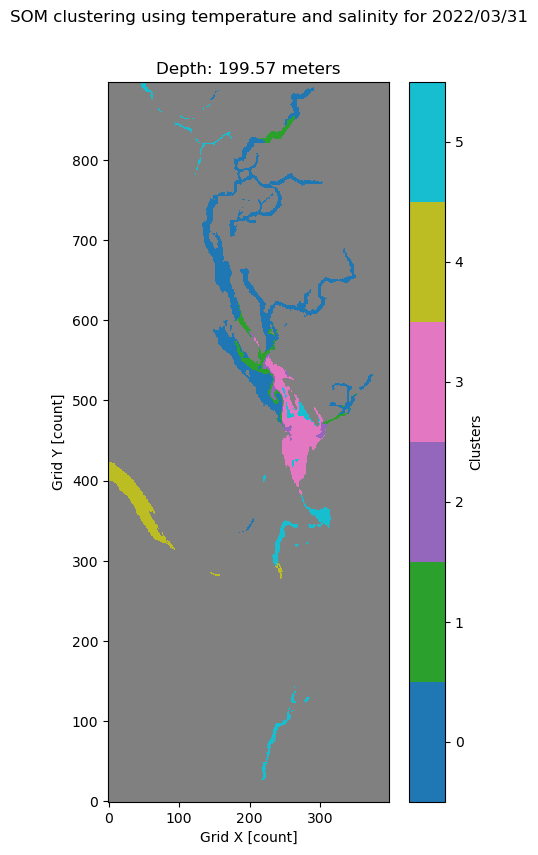

The amount of grid boxes for cluster 0 is 609 

The minimum temperature for cluster 0 is 7.63 degrees Celsius
The maximum temperature for cluster 0 is 8.28 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 29.73 g/kg
The maximum salinity for cluster 0 is 30.79 g/kg
The mean salinity for cluster 0 is 30.34 g/kg 


The amount of grid boxes for cluster 1 is 1599 

The minimum temperature for cluster 1 is 6.45 degrees Celsius
The maximum temperature for cluster 1 is 7.7 degrees Celsius
The mean temperature for cluster 1 is 7.01 degrees Celsius 

The minimum salinity for cluster 1 is 30.14 g/kg
The maximum salinity for cluster 1 is 33.95 g/kg
The mean salinity for cluster 1 is 32.95 g/kg 


The amount of grid boxes for cluster 2 is 745 

The minimum temperature for cluster 2 is 8.75 degrees Celsius
The maximum temperature for cluster 2 is 8.99 degrees Celsius
The mean temperature for cluster 2 is 8.87 degrees Celsius 

The min

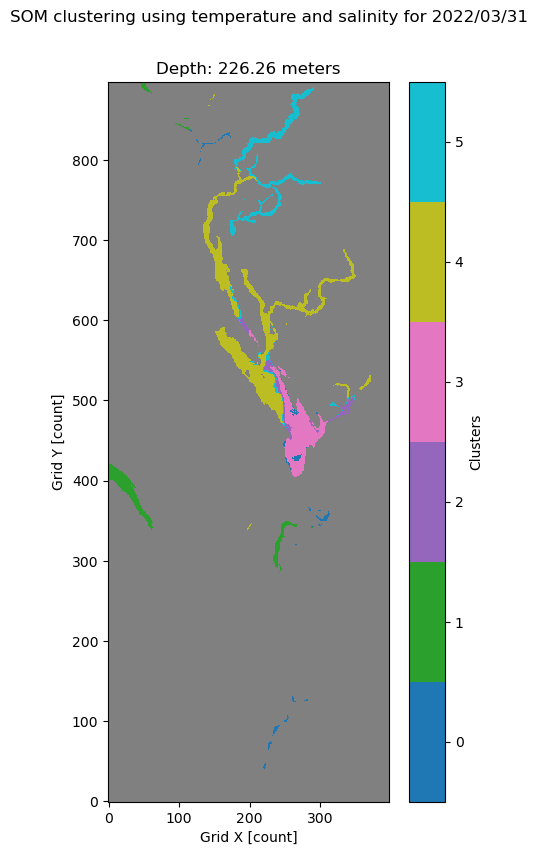

The amount of grid boxes for cluster 0 is 5686 

The minimum temperature for cluster 0 is 9.24 degrees Celsius
The maximum temperature for cluster 0 is 9.69 degrees Celsius
The mean temperature for cluster 0 is 9.33 degrees Celsius 

The minimum salinity for cluster 0 is 30.62 g/kg
The maximum salinity for cluster 0 is 31.08 g/kg
The mean salinity for cluster 0 is 30.97 g/kg 


The amount of grid boxes for cluster 1 is 1163 

The minimum temperature for cluster 1 is 9.11 degrees Celsius
The maximum temperature for cluster 1 is 9.27 degrees Celsius
The mean temperature for cluster 1 is 9.19 degrees Celsius 

The minimum salinity for cluster 1 is 30.61 g/kg
The maximum salinity for cluster 1 is 31.06 g/kg
The mean salinity for cluster 1 is 30.82 g/kg 


The amount of grid boxes for cluster 2 is 410 

The minimum temperature for cluster 2 is 8.96 degrees Celsius
The maximum temperature for cluster 2 is 9.12 degrees Celsius
The mean temperature for cluster 2 is 9.05 degrees Celsius 

The m

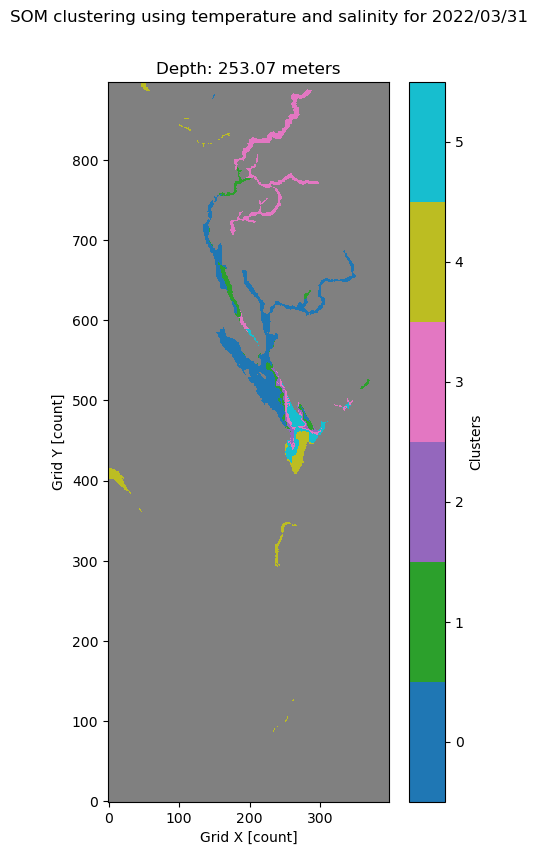

The amount of grid boxes for cluster 0 is 4811 

The minimum temperature for cluster 0 is 9.28 degrees Celsius
The maximum temperature for cluster 0 is 9.42 degrees Celsius
The mean temperature for cluster 0 is 9.37 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 31.11 g/kg
The mean salinity for cluster 0 is 31.02 g/kg 


The amount of grid boxes for cluster 1 is 968 

The minimum temperature for cluster 1 is 9.21 degrees Celsius
The maximum temperature for cluster 1 is 9.3 degrees Celsius
The mean temperature for cluster 1 is 9.25 degrees Celsius 

The minimum salinity for cluster 1 is 30.65 g/kg
The maximum salinity for cluster 1 is 31.09 g/kg
The mean salinity for cluster 1 is 30.97 g/kg 


The amount of grid boxes for cluster 2 is 638 

The minimum temperature for cluster 2 is 9.09 degrees Celsius
The maximum temperature for cluster 2 is 9.21 degrees Celsius
The mean temperature for cluster 2 is 9.16 degrees Celsius 

The min

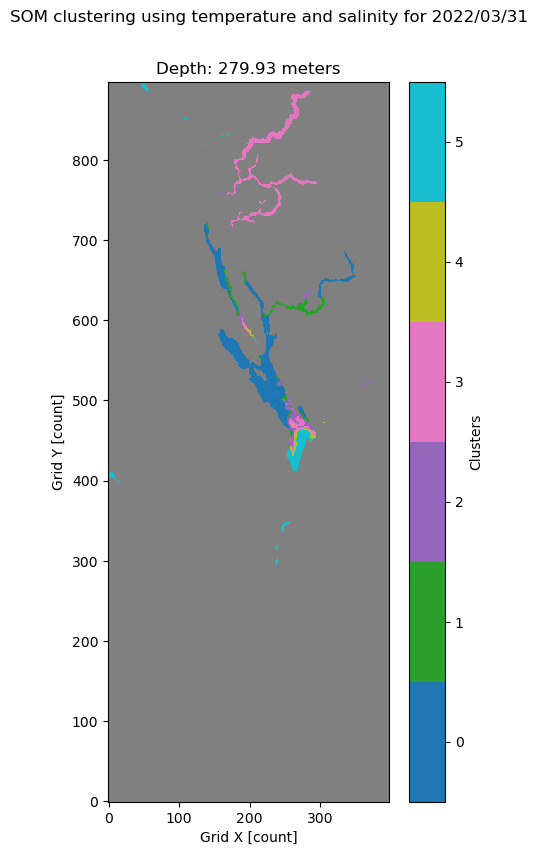

The amount of grid boxes for cluster 0 is 3569 

The minimum temperature for cluster 0 is 9.35 degrees Celsius
The maximum temperature for cluster 0 is 9.44 degrees Celsius
The mean temperature for cluster 0 is 9.4 degrees Celsius 

The minimum salinity for cluster 0 is 30.83 g/kg
The maximum salinity for cluster 0 is 31.14 g/kg
The mean salinity for cluster 0 is 31.08 g/kg 


The amount of grid boxes for cluster 1 is 1176 

The minimum temperature for cluster 1 is 9.28 degrees Celsius
The maximum temperature for cluster 1 is 9.39 degrees Celsius
The mean temperature for cluster 1 is 9.33 degrees Celsius 

The minimum salinity for cluster 1 is 30.71 g/kg
The maximum salinity for cluster 1 is 31.12 g/kg
The mean salinity for cluster 1 is 30.99 g/kg 


The amount of grid boxes for cluster 2 is 777 

The minimum temperature for cluster 2 is 9.18 degrees Celsius
The maximum temperature for cluster 2 is 9.29 degrees Celsius
The mean temperature for cluster 2 is 9.23 degrees Celsius 

The mi

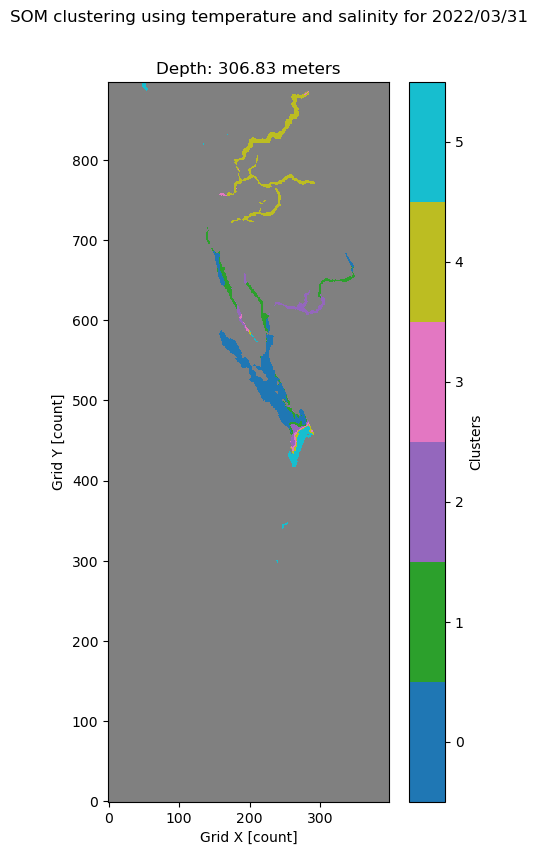

The amount of grid boxes for cluster 0 is 652 

The minimum temperature for cluster 0 is 7.6 degrees Celsius
The maximum temperature for cluster 0 is 9.0 degrees Celsius
The mean temperature for cluster 0 is 8.79 degrees Celsius 

The minimum salinity for cluster 0 is 30.57 g/kg
The maximum salinity for cluster 0 is 31.23 g/kg
The mean salinity for cluster 0 is 30.83 g/kg 


The amount of grid boxes for cluster 1 is 1505 

The minimum temperature for cluster 1 is 8.99 degrees Celsius
The maximum temperature for cluster 1 is 9.13 degrees Celsius
The mean temperature for cluster 1 is 9.03 degrees Celsius 

The minimum salinity for cluster 1 is 30.69 g/kg
The maximum salinity for cluster 1 is 31.07 g/kg
The mean salinity for cluster 1 is 30.73 g/kg 


The amount of grid boxes for cluster 2 is 351 

The minimum temperature for cluster 2 is 9.1 degrees Celsius
The maximum temperature for cluster 2 is 9.24 degrees Celsius
The mean temperature for cluster 2 is 9.2 degrees Celsius 

The minimu

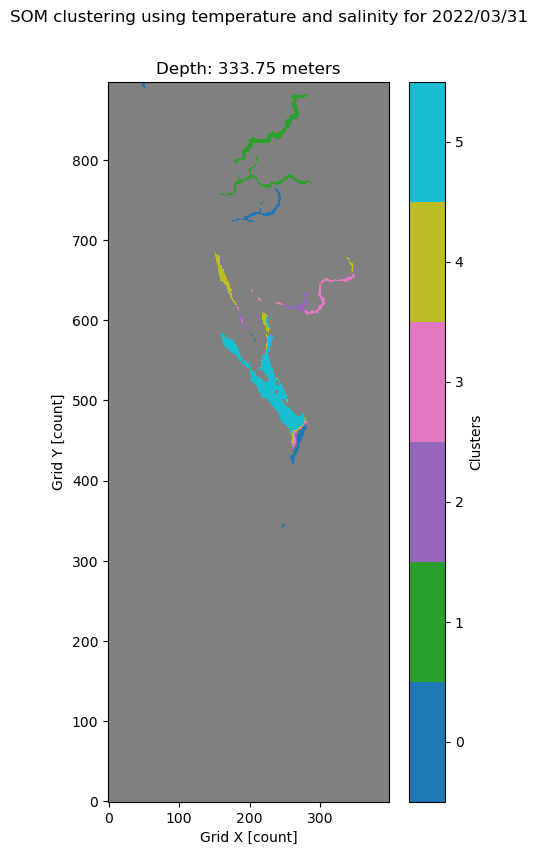

The amount of grid boxes for cluster 0 is 1485 

The minimum temperature for cluster 0 is 8.9 degrees Celsius
The maximum temperature for cluster 0 is 9.07 degrees Celsius
The mean temperature for cluster 0 is 9.01 degrees Celsius 

The minimum salinity for cluster 0 is 30.67 g/kg
The maximum salinity for cluster 0 is 31.05 g/kg
The mean salinity for cluster 0 is 30.72 g/kg 


The amount of grid boxes for cluster 1 is 177 

The minimum temperature for cluster 1 is 9.04 degrees Celsius
The maximum temperature for cluster 1 is 9.12 degrees Celsius
The mean temperature for cluster 1 is 9.07 degrees Celsius 

The minimum salinity for cluster 1 is 30.73 g/kg
The maximum salinity for cluster 1 is 31.08 g/kg
The mean salinity for cluster 1 is 30.76 g/kg 


The amount of grid boxes for cluster 2 is 341 

The minimum temperature for cluster 2 is 9.13 degrees Celsius
The maximum temperature for cluster 2 is 9.25 degrees Celsius
The mean temperature for cluster 2 is 9.21 degrees Celsius 

The min

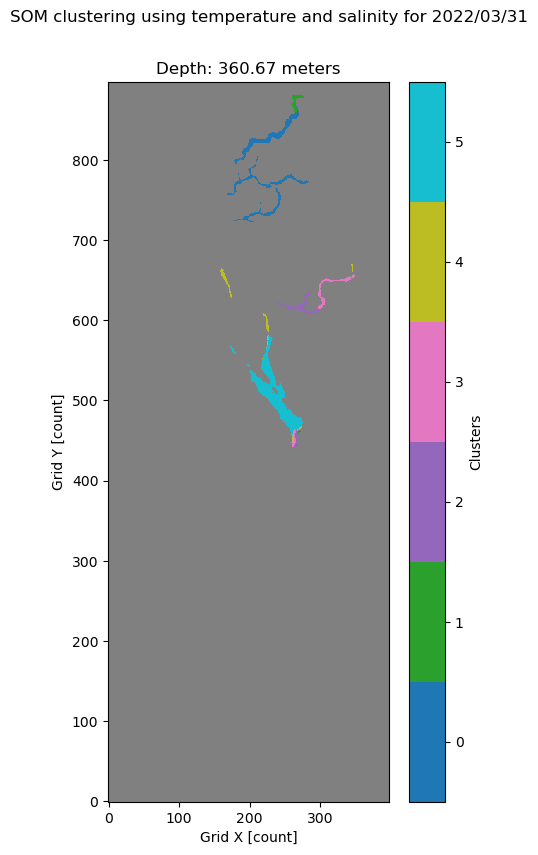

The amount of grid boxes for cluster 0 is 198 

The minimum temperature for cluster 0 is 9.06 degrees Celsius
The maximum temperature for cluster 0 is 9.08 degrees Celsius
The mean temperature for cluster 0 is 9.07 degrees Celsius 

The minimum salinity for cluster 0 is 30.73 g/kg
The maximum salinity for cluster 0 is 30.74 g/kg
The mean salinity for cluster 0 is 30.74 g/kg 


The amount of grid boxes for cluster 1 is 1208 

The minimum temperature for cluster 1 is 8.92 degrees Celsius
The maximum temperature for cluster 1 is 9.06 degrees Celsius
The mean temperature for cluster 1 is 9.0 degrees Celsius 

The minimum salinity for cluster 1 is 30.68 g/kg
The maximum salinity for cluster 1 is 30.77 g/kg
The mean salinity for cluster 1 is 30.73 g/kg 


The amount of grid boxes for cluster 2 is 312 

The minimum temperature for cluster 2 is 9.22 degrees Celsius
The maximum temperature for cluster 2 is 9.34 degrees Celsius
The mean temperature for cluster 2 is 9.28 degrees Celsius 

The min

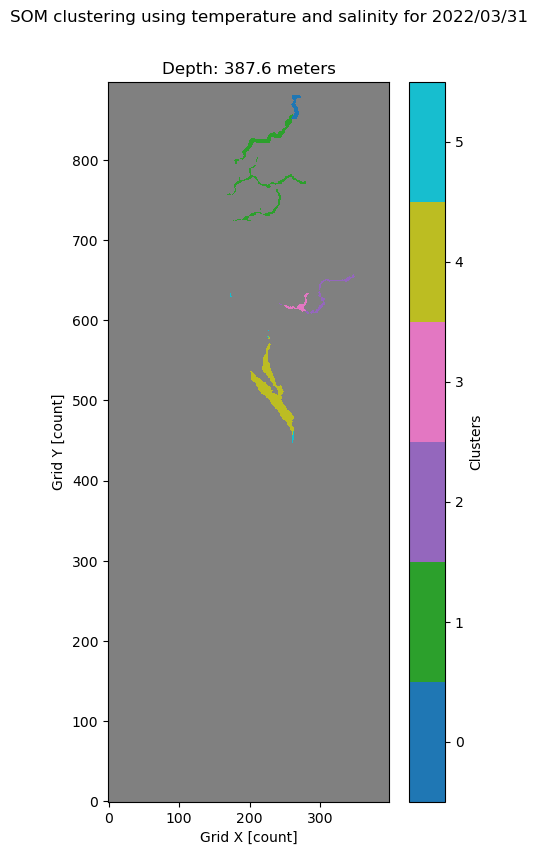

The amount of grid boxes for cluster 1 is 459 

The minimum temperature for cluster 1 is 9.42 degrees Celsius
The maximum temperature for cluster 1 is 9.45 degrees Celsius
The mean temperature for cluster 1 is 9.44 degrees Celsius 

The minimum salinity for cluster 1 is 31.13 g/kg
The maximum salinity for cluster 1 is 31.18 g/kg
The mean salinity for cluster 1 is 31.17 g/kg 


The amount of grid boxes for cluster 3 is 248 

The minimum temperature for cluster 3 is 9.2 degrees Celsius
The maximum temperature for cluster 3 is 9.3 degrees Celsius
The mean temperature for cluster 3 is 9.25 degrees Celsius 

The minimum salinity for cluster 3 is 31.08 g/kg
The maximum salinity for cluster 3 is 31.13 g/kg
The mean salinity for cluster 3 is 31.11 g/kg 




IndexError: index 4 is out of bounds for axis 0 with size 4

In [14]:
ds, temp, saline, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline = masking(depth, temp, saline, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
